In [21]:
import pandas as pd
df = pd.read_csv("HDFCBANK.csv")
#df.columns=['Date', 'Open', 'High', 'Low', 'Close', 'Volume']
#Check if NA values are in data
df=df[df['Volume']!=0]
df.reset_index(drop=True, inplace=True)
df.isna().sum()
df.head(10)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2013-01-01,341.049988,342.549988,339.825012,342.250000,315.591309,2014606.0
1,2013-01-02,344.950012,345.000000,341.524994,343.674988,316.905304,4854798.0
2,2013-01-03,345.000000,345.000000,340.200012,341.674988,315.061035,4571366.0
3,2013-01-04,342.500000,342.500000,336.399994,339.674988,313.216827,5442254.0
4,2013-01-07,341.850006,341.850006,333.000000,334.100006,308.076141,5502284.0
5,2013-01-08,334.000000,336.700012,332.850006,335.125000,309.021332,4942598.0
6,2013-01-09,336.000000,336.274994,333.024994,333.750000,307.753387,6435982.0
7,2013-01-10,334.750000,339.000000,333.250000,337.899994,311.580109,4565184.0
8,2013-01-11,338.450012,338.450012,333.350006,334.649994,308.583313,5141714.0
9,2013-01-14,334.075012,335.250000,333.549988,334.649994,308.583313,5694874.0


In [22]:
def pivotid(df1, l, n1, n2): #n1 n2 before and after candle l
    if l-n1 < 0 or l+n2 >= len(df1):
        return 0
    
    pividlow=1
    pividhigh=1
    for i in range(l-n1, l+n2+1):
        if(df1.Low[l]>df1.Low[i]):
            pividlow=0
        if(df1.High[l]<df1.High[i]):
            pividhigh=0
    if pividlow and pividhigh:
        return 3
    elif pividlow:
        return 1
    elif pividhigh:
        return 2
    else:
        return 0
    
df['pivot'] = df.apply(lambda x: pivotid(df, x.name,20,20), axis=1)
df['shortpivot'] = df.apply(lambda x: pivotid(df, x.name,8,8), axis=1)

In [23]:
import numpy as np
def pointpos(x):
    if x['pivot']==1:
        return x['Low']-25
    elif x['pivot']==2:
        return x['High']+25
    else:
        return np.nan

def shortpointpos(x):
    if x['shortpivot']==1:
        return x['Low']-75
    elif x['shortpivot']==2:
        return x['High']+75
    else:
        return np.nan
    
df['pointpos'] = df.apply(lambda row: pointpos(row), axis=1)
df['shortpointpos'] = df.apply(lambda row: shortpointpos(row), axis=1)

In [24]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from datetime import datetime
dfpl = df[-1000:]
fig = go.Figure(data=[go.Candlestick(x=dfpl.index,
                open=dfpl['Open'],
                high=dfpl['High'],
                low=dfpl['Low'],
                close=dfpl['Close'])])

fig.add_scatter(x=dfpl.index, y=dfpl['pointpos'], mode="markers",
                marker=dict(size=5, color="MediumPurple"),
                name="pivot")
fig.add_scatter(x=dfpl.index, y=dfpl['shortpointpos'], mode="markers",
                marker=dict(size=5, color="red"),
                name="shortpivot")
fig.update_layout(xaxis_rangeslider_visible=False)
fig.show()

In [ ]:
The purple coloured dots denote strong pivots and the red coloured dots denote weak pivot point and we take the descision to sell and buy accordingly. The head and shoulders pattern act as a safeguard to false macd signal and also help in identifying reversal of trend.

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from warnings import simplefilter
import yfinance as yf

In [28]:
data=yf.download('HDFCBANK.NS', start="2010-01-01", end="2020-01-01")

[*********************100%***********************]  1 of 1 completed


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


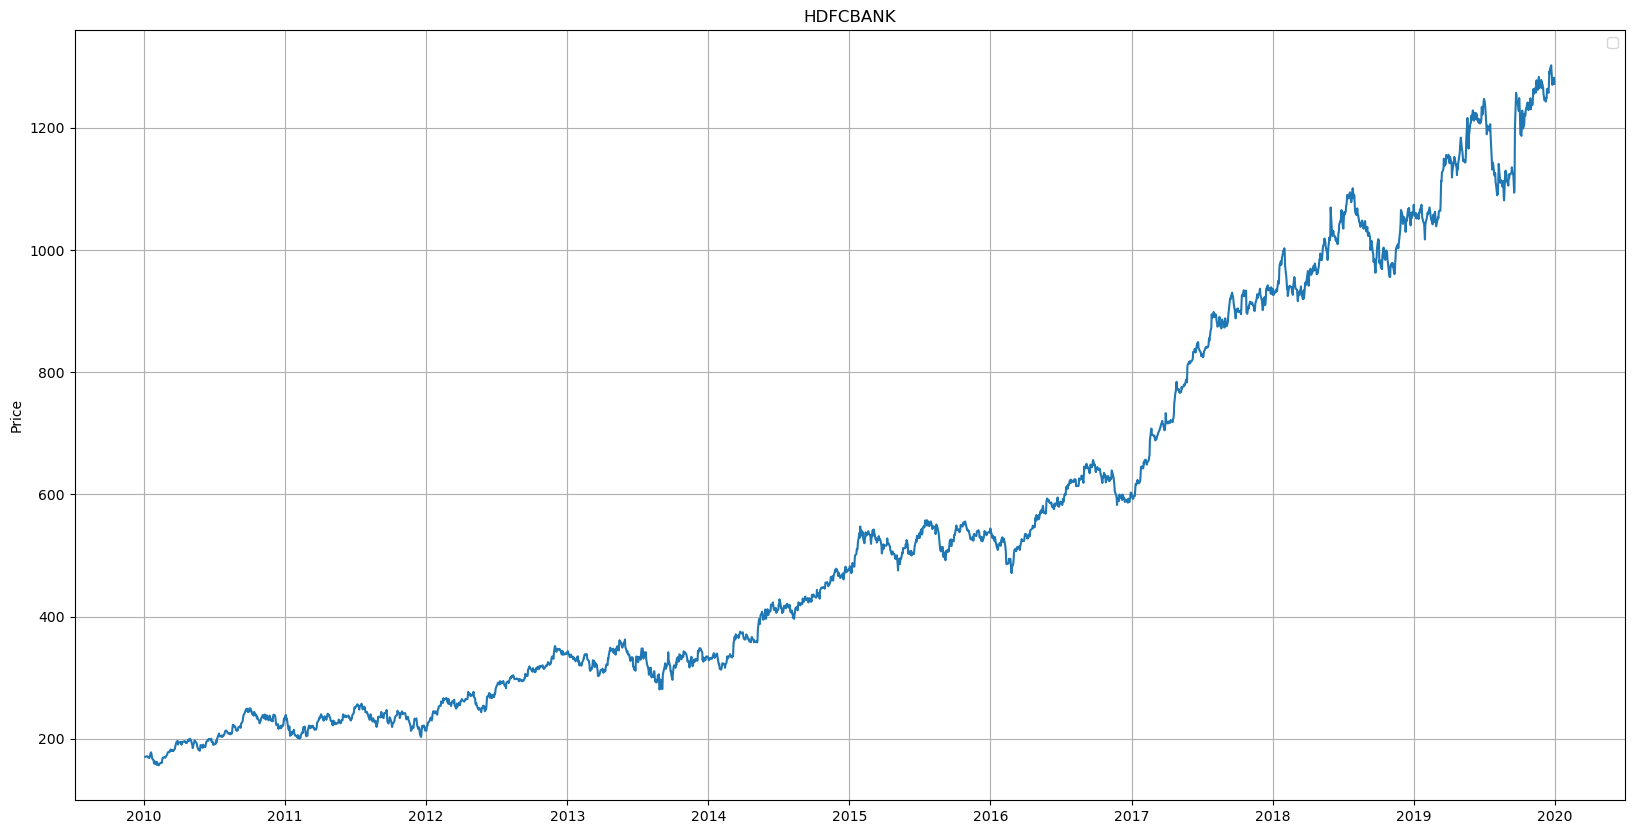

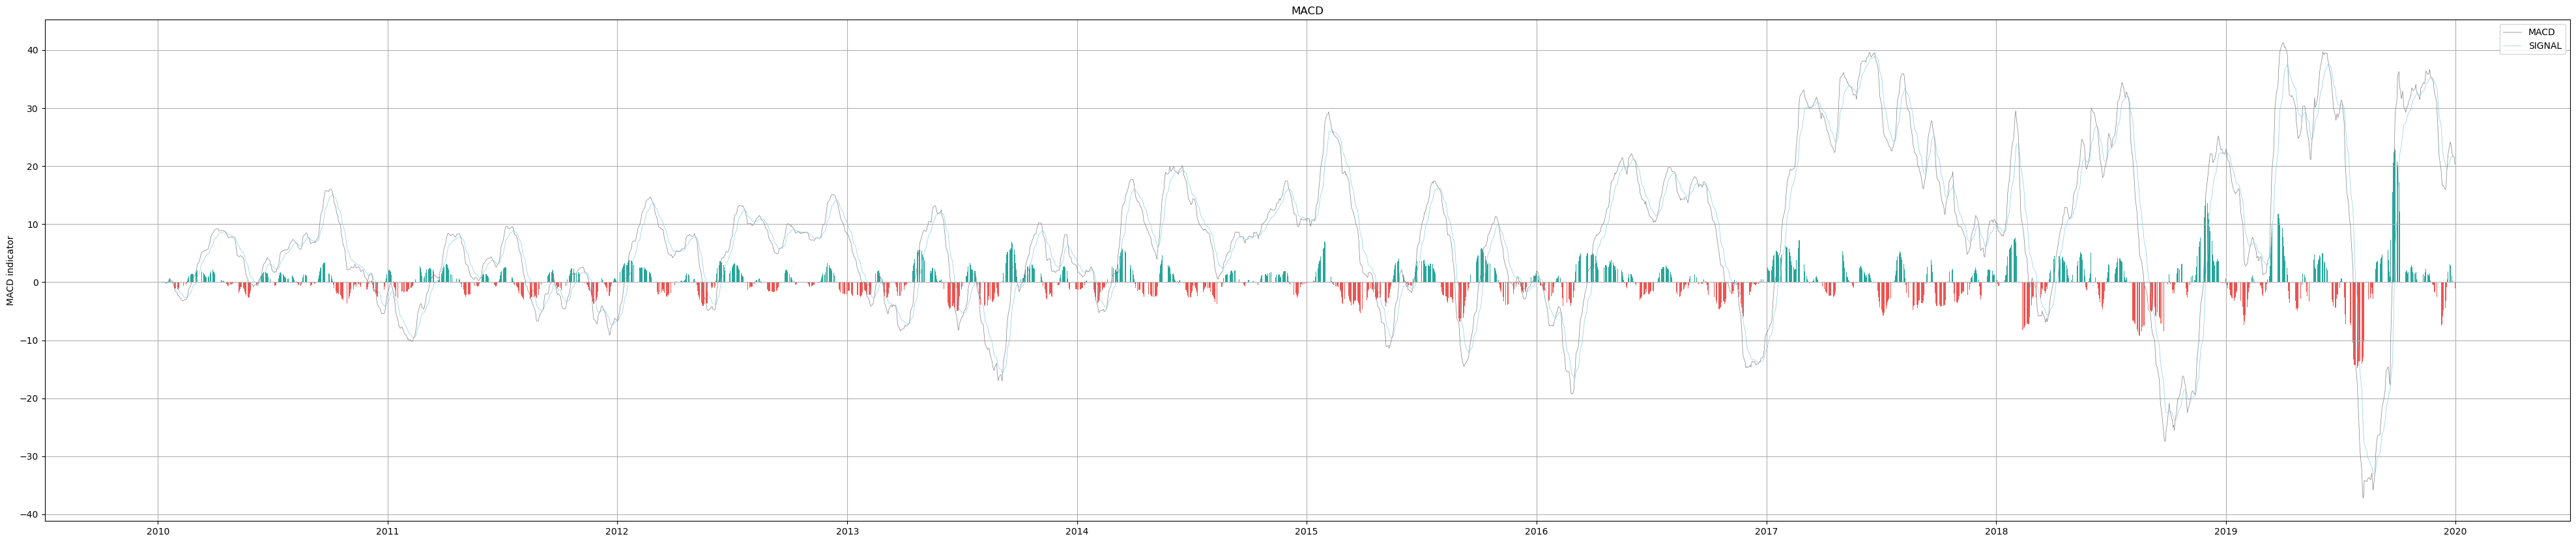

In [59]:
data['MACD']=data['Close'].ewm(span=15).mean()-data['Close'].ewm(span=50).mean()
data['Signal']=data['MACD'].ewm(span=10).mean()
data['Histogram']=data['MACD']-data['Signal']

plt.figure(figsize=(20, 10))
plt.plot(data['Close'])


plt.legend(loc = 'lower right')
plt.ylabel('Price')
plt.title('HDFCBANK')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(50, 10))
plt.plot(data['MACD'], color = 'grey', linewidth = 0.5, label = 'MACD')
plt.plot(data['Signal'], color = 'skyblue', linewidth = 0.5, label = 'SIGNAL')

for i in range(len(data['Histogram'])):
    if str(data['Histogram'][i])[0] == '-':
        plt.bar(data['Close'].index[i], data['Histogram'][i], color = '#ef5350')
    else:
        plt.bar(data['Close'].index[i], data['Histogram'][i], color = '#26a69a')

plt.legend(loc = 'lower right')
plt.ylabel('MACD indicator')
plt.title('MACD')
plt.legend()
plt.grid(True)
plt.show()

In [60]:
def implement_macd_strategy(data):    
    buy_price = []
    sell_price = []
    macd_signal = []
    signal = 0

    for i in range(len(data)):
        if data['MACD'][i] > data['Signal'][i]:
            if signal != 1:
                buy_price.append(data['Close'][i])
                sell_price.append(np.nan)
                signal = 1
                macd_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                macd_signal.append(0)
        elif data['MACD'][i] < data['Signal'][i]:
            if signal != -1:
                buy_price.append(np.nan)
                sell_price.append(data['Close'][i])
                signal = -1
                macd_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                macd_signal.append(0)
        else:
            buy_price.append(np.nan)
            sell_price.append(np.nan)
            macd_signal.append(0)
            
    return buy_price, sell_price, macd_signal
            
buy_price, sell_price, macd_signal = implement_macd_strategy(data)

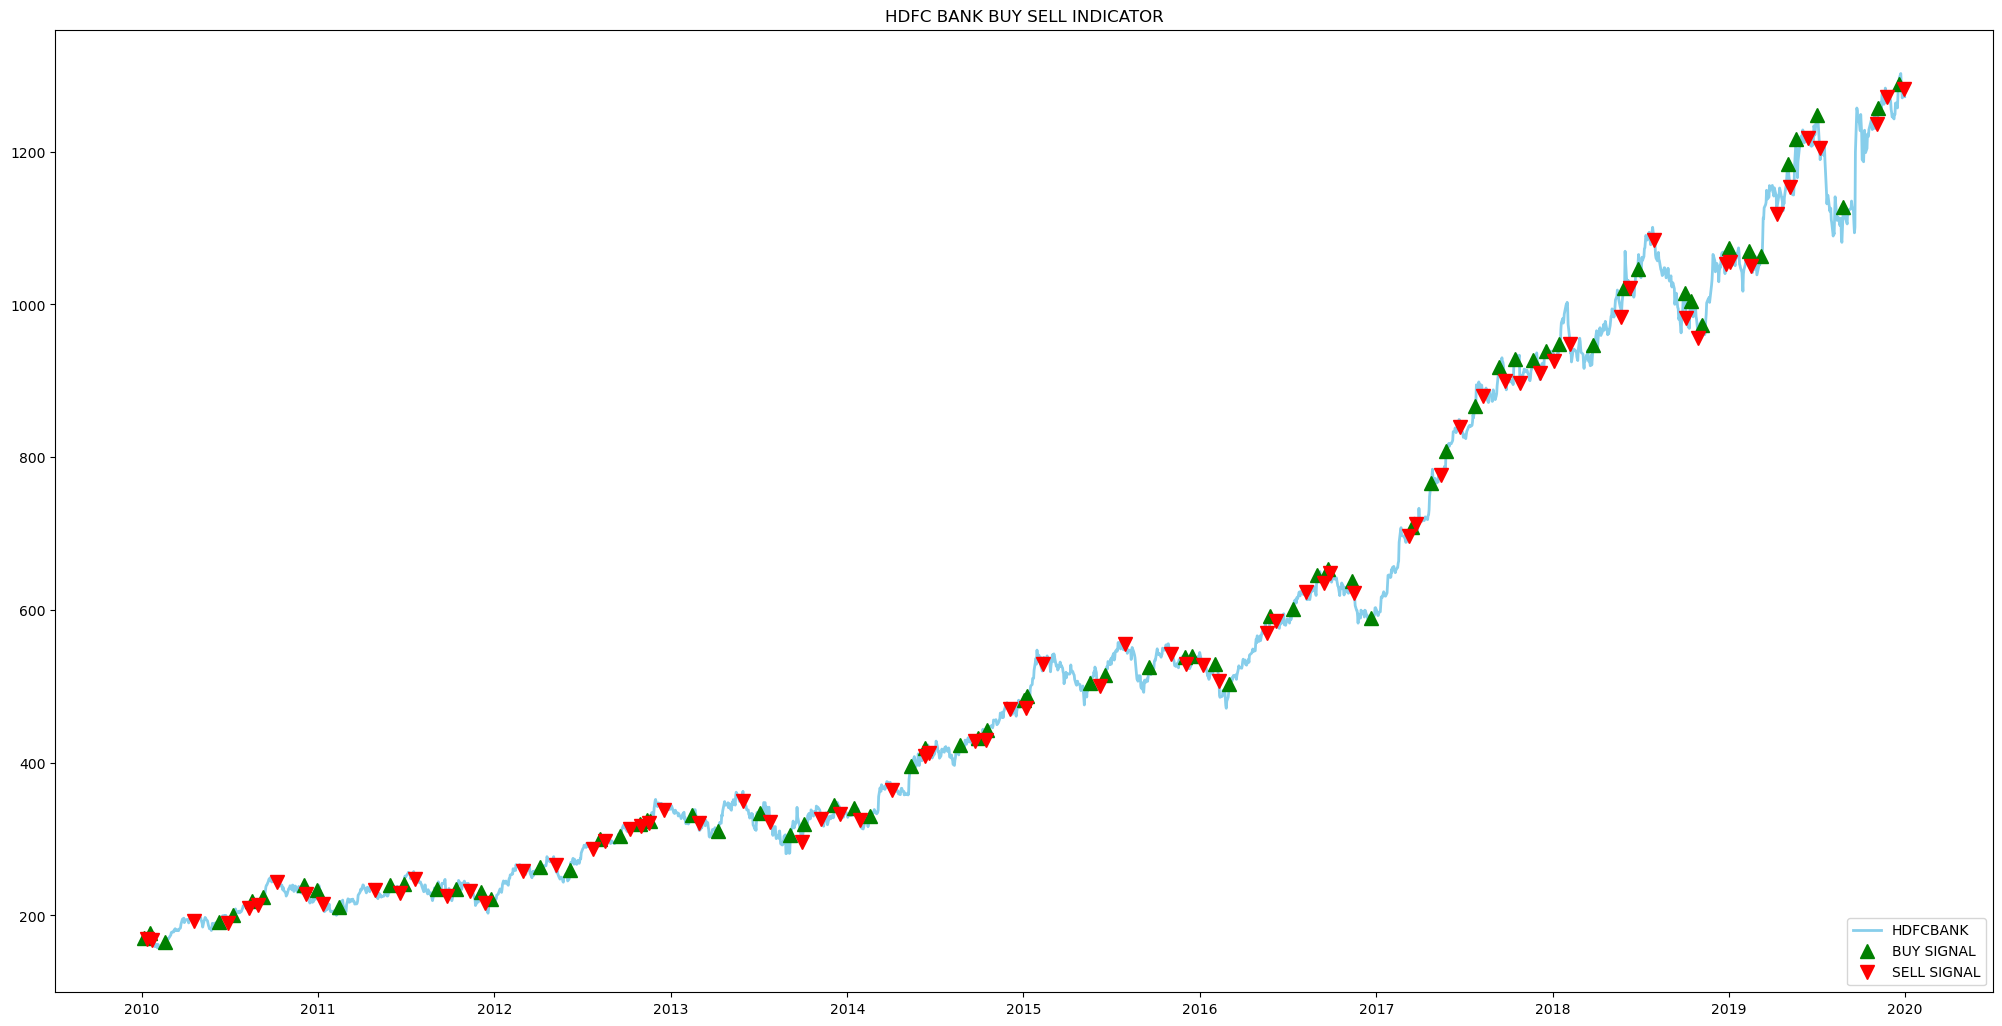

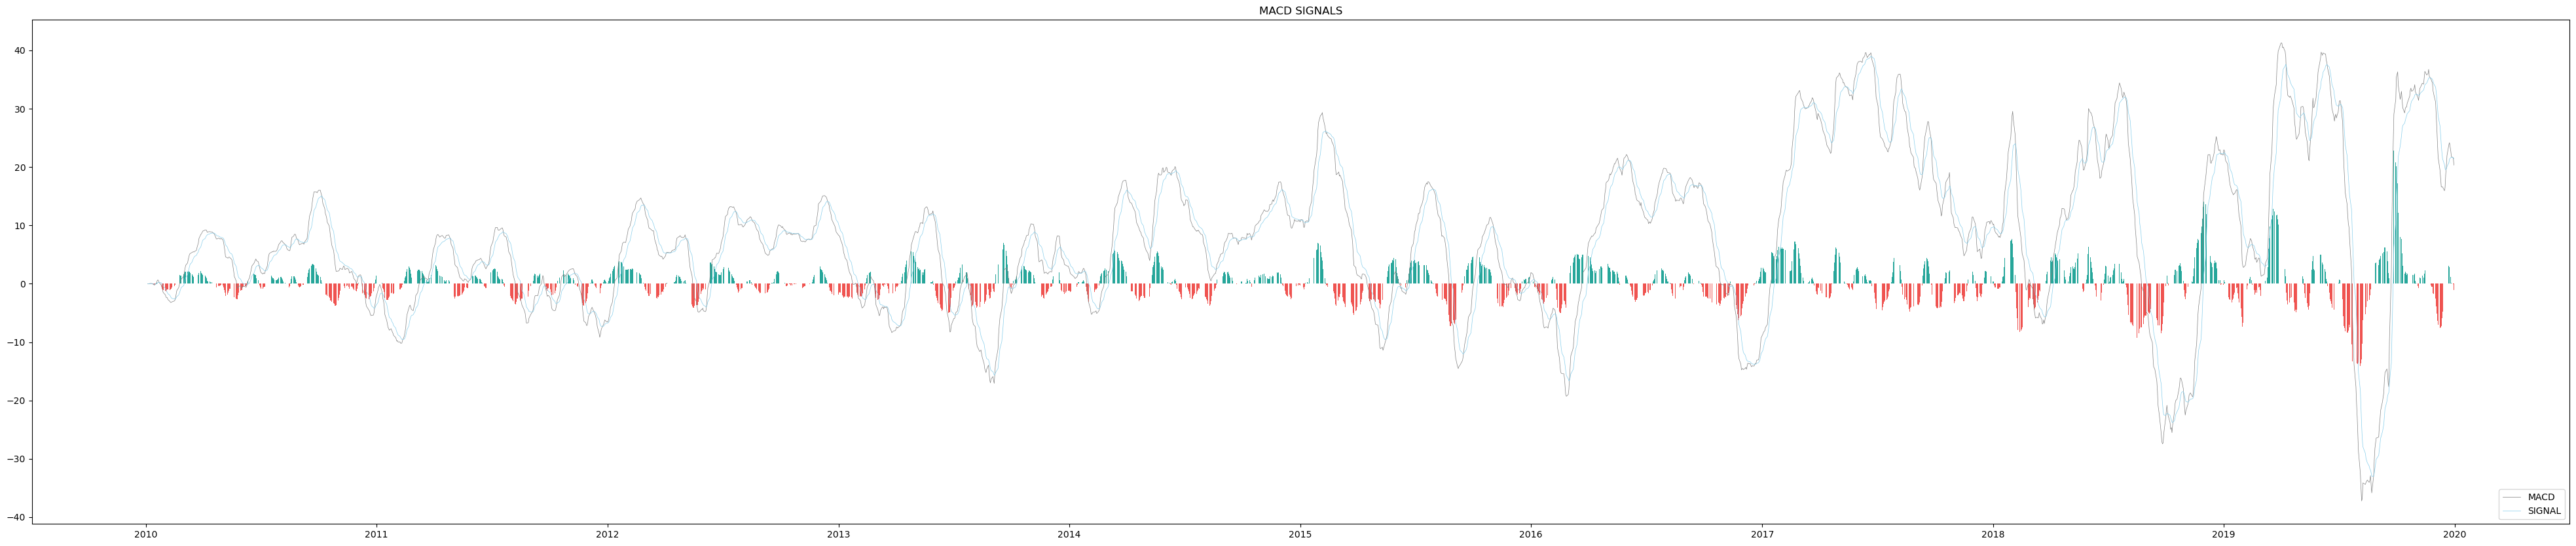

In [61]:
plt.figure(figsize=(25, 12.5))
plt.plot(data['Close'], color = 'skyblue', linewidth = 2, label = 'HDFCBANK')
plt.plot(data.index, buy_price, marker = '^', color = 'green', markersize = 10, label = 'BUY SIGNAL', linewidth = 0)
plt.plot(data.index, sell_price, marker = 'v', color = 'r', markersize = 10, label = 'SELL SIGNAL', linewidth = 0)
#plt.legend()
plt.title('HDFC BANK BUY SELL INDICATOR')

plt.legend(loc = 'lower right')
plt.show()

plt.figure(figsize=(50, 10))
plt.plot(data['MACD'], color = 'grey', linewidth = 0.5, label = 'MACD')
plt.plot(data['Signal'], color = 'skyblue', linewidth = 0.5, label = 'SIGNAL')

for i in range(len(data['Histogram'])):
    if str(data['Histogram'][i])[0] == '-':
        plt.bar(data['Close'].index[i], data['Histogram'][i], color = '#ef5350')
    else:
        plt.bar(data['Close'].index[i], data['Histogram'][i], color = '#26a69a')
plt.title('MACD SIGNALS')        
plt.legend(loc = 'lower right')
plt.show()

In [62]:
position = []
for i in range(len(data['Signal'])):
    if macd_signal[i] > 1:
        position.append(0)
    else:
        position.append(1)
        
for i in range(len(data['Close'])):
    if macd_signal[i] == 1:
        position[i] = 1
    elif macd_signal[i] == -1:
        position[i] = 0
    else:
        position[i] = position[i-1]
        
macd = data['MACD']
signal = data['Signal']
close_price = data['Close']
macd_signal = pd.DataFrame(macd_signal).rename(columns = {0:'macd_signal'}).set_index(data.index)
position = pd.DataFrame(position).rename(columns = {0:'macd_position'}).set_index(data.index)

frames = [close_price, macd, signal, macd_signal, position]
strategy = pd.concat(frames, join = 'inner', axis = 1)

strategy

,Close,MACD,Signal,macd_signal,macd_position
Date,,,,,
2010-01-04,170.570007,0.000000,0.000000,0,1
2010-01-05,170.720001,0.003500,0.001925,1,1
2010-01-06,170.835007,0.008196,0.004446,0,1
2010-01-07,171.279999,0.026667,0.011767,0,1
2010-01-08,171.505005,0.045723,0.021515,0,1
...,...,...,...,...,...
2019-12-24,1289.150024,24.181319,21.369321,0,1
2019-12-26,1270.449951,22.744403,21.619336,0,1
2019-12-27,1275.000000,21.815239,21.654954,0,1


In [34]:
!pip install termcolor

In [38]:
import math
from termcolor import colored as cl

In [63]:
HDFC_ret = pd.DataFrame(np.diff(data['Close'])).rename(columns = {0:'returns'})
macd_strategy_ret = []
for i in range(len(HDFC_ret)):
    try:
        returns = HDFC_ret['returns'][i]*strategy['macd_position'][i]
        macd_strategy_ret.append(returns)
    except:
        pass
    
macd_strategy_ret_df = pd.DataFrame(macd_strategy_ret).rename(columns = {0:'macd_returns'})

investment_value = 100000
number_of_stocks = math.floor(investment_value/data['Close'][0])
macd_investment_ret = []

for i in range(len(macd_strategy_ret_df['macd_returns'])):
    returns = number_of_stocks*macd_strategy_ret_df['macd_returns'][i]
    macd_investment_ret.append(returns)
   
macd_investment_ret_df = pd.DataFrame(macd_investment_ret).rename(columns = {0:'investment_returns'})
total_investment_ret = round(sum(macd_investment_ret_df['investment_returns']), 2) 
profit_percentage = math.floor((total_investment_ret/investment_value)*100)
print(cl('Profit gained from the MACD strategy by investing Rs 100k in NSE : {}'.format(total_investment_ret), attrs = ['bold']))
print(cl('Profit percentage of the MACD strategy : {}%'.format(profit_percentage), attrs = ['bold']))

Profit gained from the MACD strategy by investing Rs 100k in NSE : 263313.25
Profit percentage of the MACD strategy : 263%


In [64]:
returns=macd_investment_ret_df['investment_returns']/1000
cum_ret_c=0
cum_returns=[]
for i in range(len(HDFC_ret)):
    if (i==0): 
        cum_returns.append(returns[0])
        cum_ret_c+=returns[0]
    else: 
        cum_ret_c+=returns[i]
        cum_returns.append(cum_ret_c)
cum_returns_df=pd.DataFrame(cum_returns).rename(columns = {0:'cum_returns'})
print(cum_returns_df.iloc[-1])

volatility=returns.std()*np.sqrt(252)
print(volatility)

rolling_max=cum_returns_df.rolling(window=len(cum_returns_df), min_periods=1).max()
drawdown=(cum_returns_df/rolling_max)-1
max_drawdown=drawdown.min()
print(max_drawdown)

sharpe_ratio=(returns.mean()-(0.02/252))*np.sqrt(252)/returns.std()
print(sharpe_ratio)

cum_returns    263.313247
Name: 2460, dtype: float64
50.055564516391634
cum_returns   -11.700552
dtype: float64
0.5382536780464897
